[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


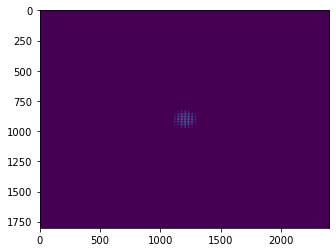

[[0.05854983 0.09653235 0.05854983]
 [0.09653235 0.15915494 0.09653235]
 [0.05854983 0.09653235 0.05854983]]


'\n0 0 1 0 1 0 0\n0 1 0 1 0 1 0\n\n\n'

In [13]:
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import islice
import matplotlib.image as mpimg
from numpy import pi, exp, sqrt



#find graduint of the image in x and y, then equate to zero
#and solvee


def read_image(image_name):
    """
    Read image

    Inputs:
    ----------------
        image_name   Image path

    Output:
    ----------------
        img  Image as multi channel array
       """
    img = mpimg.imread(image_name)
    #im_array = np.array(img)

    return img



def matrix_fft(pattern):
    """
    FFT of the input array

    Inputs:
    ----------------
        pattern   2D array

    Output:
    ----------------
        fft2   FFT of array

     """
    #Take FFt along columns, then rows
    fft1 = np.fft.fft(pattern, axis = 0)
    fft2 = np.fft.fft(fft1, axis = 1)

    return fft2

def matrix_ifft(pattern):
    """
    IFFT of the input array

    Inputs:
    ----------------
        pattern   2D array

    Output:
    ----------------
        ifft2   FFT of array

     """

    #Take IFFt along columns, then rows
    ifft1 = np.fft.ifft(pattern, axis = 0)
    ifft2 = np.fft.ifft(ifft1, axis = 1)

    return ifft2


def matrix_complex_conj(pattern):
    """
    Complex of the input array

    Inputs:
    ----------------
        pattern   2D array

    Output:
    ----------------
        pattern_fft_conj   Complex conjugate of array

     """

    pattern_fft_conj = np.conj(pattern)

    return pattern_fft_conj



def zero_padding(C, x_pad, y_pad):
    """
    Zero pad 2D array by placing it in centre of zeroed matrix of padded size.

    Inputs:
    ----------------
        array   The array to pad

        padlen_x    Padwidth of the rows. Floats will be rounded up.

        padlen_y    Padwidth of the columns. Floats will be rounded up.

    Output:
    ----------------
        padded  Padded template array.
     """

    # m,n = c_x.shape

    # #needs to be int to work not float make this into a round up if float function or find libray function
    # if padlen_x% 2 == 0:
    #     padlen_x = int(padlen_x)
    # else:
    #     padlen_x = int( padlen_x + 0.5 )

    # if padlen_y% 2 == 0:
    #     padlen_y = int(padlen_y)
    # else:
    #     padlen_y = int( padlen_y + 0.5 )

    # c_y = np.zeros((m +2*padlen_x , n+2*padlen_y ),dtype=c_x.dtype)
    # c_y[padlen_x:-padlen_x:, padlen_y:-padlen_y] = c_x
    # return c_y


    x_pad = int(np.round(x_pad))
    y_pad = int(np.round(y_pad))

    return np.pad(C, [(x_pad, ), (y_pad, )], mode='constant')


def crr_2d( pattern, template):
    """
    Cross correlation of two 2D arrays using FFt to convolve spatial arrays

    Inputs:
    ----------------
        pattern   Pattern must be non empty

        template   Template, search space with similar dimensionality to pattern

    Output:
    ----------------
        real_corr  Cross correlation array
     """

    side_edge_pad = template.shape[0] - pattern.shape[0] # move into zero padding function
    bottom_edge_pad = template.shape[1] - pattern.shape[1]

    pattern_padded = zero_padding( pattern, side_edge_pad /2, bottom_edge_pad /2 ) # pad pattern as centre of array with zeros

    template_fft = matrix_fft(template) #(a)
    pattern_fft_conj = matrix_complex_conj( matrix_fft(pattern_padded) ) # (b)

    # a * b
    #Offset pattern due to padding
    product = pattern_fft_conj[0: pattern_fft_conj.shape [0],0: pattern_fft_conj.shape [1]] *  template[:, 0: template.shape[1] -1 ]

    ccr = matrix_ifft(product)

    real_corr = np.real(ccr) #np.real

    return real_corr

#function that finds the largest element and its index in an array
def find_best_match(score):
    """
    Find max value in 2D array and its index

    Inputs:
    ----------------
        score   2D target array

    Output:
    ----------------
        index   Index of largest element

        max_element Max Element in the array

     """
    #try:
    max_element = np.amax(score)
    #except:
    #    print( "Line 45 Error", score )
    index = np.unravel_index(np.argmax( score, axis=None), score.shape)
    #index = np.argmax(score)

    return index, max_element # tuple = list, int


def find_offset(pattern, template):
    """
    2D array offset index and value from cross correlation

    Inputs:
    ----------------
        pattern   Pattern must be non empty

        template   Template, search space with similar dimensionality to pattern

    Output:
    ----------------
        (best_score, best_match)  Index of offset found from cross correlation
     """

    real_corr = crr_2d( pattern, template)


    best_match , match_value = find_best_match( real_corr )
    #print( best_match )

    return (best_match[0] - 2 * pattern.shape[0], best_match[1] - 2 * pattern.shape[1]), match_value


# 2nd way

def gauss_2d( k ):
    probs = []
    s = 1
    k = k // 2   # 17 / 9 = 1.99   17 // 9 = 1       int(17/9)    3//2 = 1
    # (1/sqrt(2pi*s*s))*exp(-(z)^2/2s*s)  for u=0
    # z = -1 , 0 , 1 for k = 1
    for z in range(-k, k+1):
        probs.append(exp(-z*z/(2*s*s))/sqrt(2*pi*s*s))
    kernel = np.outer(probs, probs)

    return kernel



# test = read_image("test_left_tiff.tiff")

# size_test = test.shape()

gaussian = gauss_2d(3)


# corr = crr_2d(gaussian, test)
#
# best = find_best_match( corr)
# max = []
# threshold = 0.001
# dots = np.zeros(corr.shape[0], corr.shape[1])  # gives a matrix of n x m with all zeros in it
# for i in range( corr.shape[0] ):
#     for j in range(corr.shape[1]):
#             if corr[i ,j] >= threshold:
#                 max.append((i,j))  # [(1,2), (1,3), (2,4)...]
#                 dots[i,j] = 1


gaussian = gauss_2d(3)
img = read_image("test_left_1.tiff")
image_mean_1= img[:,:,0:3].mean(axis=2)
corr = crr_2d(gaussian, image_mean_1)


best = find_best_match( corr)
max = []
threshold = 0.001
dots = np.zeros( (corr.shape[0], corr.shape[1] ) )   # gives a matrix of n x m with all zeros in it
for i in range( corr.shape[0] ):
    for j in range(corr.shape[1]):
            if corr[i ,j] >= threshold:
                max.append((i,j))  # [(1,2), (1,3), (2,4)...]
                dots[i,j] = 1
                #dot = Circle((i, j), 10)
                #img.add_path(dot)

print(dots)

from matplotlib.patches import Circle #draw on image



#lookup gaussian filter and gaussian peak detection
# np.where(condition)



plt.imshow(dots)
plt.show()
print(gaussian)

# plt.imshow(gaussian)

# plt.show()


'''
0 0 1 0 1 0 0
0 1 0 1 0 1 0


'''


